In [4]:
import os
import sys

sys.path.append("/home/jovyan/marineHeatWaves")
import marineHeatWaves as mh

import xarray as xr
import numpy as np

from dask.distributed import Client, progress

from datetime import date, datetime

from functools import partial

import gcsfs

import cartopy.crs as ccrs
import cartopy.feature as cf

from pandas import Timestamp

import matplotlib.pyplot as plt
%matplotlib inline

from multiprocessing import Pool

from numba import float64, guvectorize, jit

GCP_PROJECT_ID = '170771369993'
OISST_GCP = 'oisst/oisst.zarr'

%matplotlib inline

# Marine Heatwaves in OISST Data

We're using [`marineHeatWaves.py`](https://github.com/ecjoliver/marineHeatWaves) to compute the MHW metrics we need. I'd like to use Xarray for this to paralellize it over all the data. 

Since the `detect` function provided above is a 1-D function (e.g. operates on a single "pixel" of SST history data), we need to vectorize it across the OISST xarray data object. 

I followed [this guide](http://xarray.pydata.org/en/latest/examples/apply_ufunc_vectorize_1d.html) for this.

## Write 1-D MHW `detect` for xarray OISST

In [5]:
def mhw_1d(temps, time):
    
    # handle no data 
    if(np.isnan(temps).any()): return xr.DataArray(
        np.full_like(temps, np.nan), 
        name = 'mhw', 
        dims = 'time', 
        coords ={
            'time': time
        }
    )
    
    # re-orient dates into ordinal
    ordinals =  np.array([Timestamp(t).toordinal() for t in time])
    # MHw detection
    dets = mh.detect(ordinals, temps.copy())
    
    # re-orient "events" into boolean timeseries
    events = dets[0]['n_events']
    del dets[0]['n_events']
    
    arrays = {
        key: xr.DataArray(np.full_like(time, False, dtype='bool'),
                          name = key, dims='time',
                          coords={
                              'time' : time,
                          })
        for key in ['mhw', 'mhw_cum_intensity']
    }
    for event in range(events):
        start_date = dets[0]['date_start'][event]
        end_date = dets[0]['date_end'][event]
        cum_intense = dets[0]['intensity_cumulative'][event]

        arrays['mhw'].loc[dict(time=slice(start_date, end_date))] = True
        arrays['mhw_cum_intensity'].loc[dict(time=slice(start_date, end_date))] == cum_intense
        
    clim = xr.DataArray(dets[1]['thresh'], name='clim_thresh', dims='time', coords={'time': time})
        
    return (arrays['mhw'], arrays['mhw_cum_intensity'])

## Parallelize via `xr.apply_ufunc`

In [6]:
def xr_mhw_detect(oisst):
    a = xr.apply_ufunc(
        mhw_1d, 
        oisst.sst.chunk({'lat': 5, 'lon': 5, 'time': -1}), 
        oisst.time, 
        input_core_dims = [['time'], ['time']],
        output_core_dims=[["time"], ["time"]], 
        vectorize=True, 
        dask='parallelized', 
        output_dtypes=['bool']
    )
    return a

## Test on PNW Region

In [7]:
## make a local cluster
client = Client()
client.cluster.scale(16)

In [ ]:
fs = gcsfs.GCSFileSystem(project=GCP_PROJECT_ID, token="/home/jovyan/gc-pangeo.json")
oisst = xr.open_zarr(fs.get_mapper(OISST_GCP))
oisst = oisst.assign_coords(lon=(((oisst.lon + 180) % 360) - 180)).sortby('lon')
oisst.sst.data

In [ ]:
PNW_LAT = slice(0, 50)
PNW_LON = slice(-170, -150)

### Persist the data locally

In [7]:
oisst_region = oisst.sel(lat = PNW_LAT, lon = PNW_LON)
oisst_region

<xarray.Dataset>
Dimensions:  (lat: 200, lon: 80, time: 13636)
Coordinates:
  * lat      (lat) float32 0.125 0.375 0.625 0.875 ... 49.375 49.625 49.875
  * lon      (lon) float32 -169.875 -169.625 -169.375 ... -150.375 -150.125
  * time     (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2018-12-31
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(100, 40, 80), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.5
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    history:        Thu Aug 24 13:34:17 2017: ncatted -O -a References,global...
    institution:    NOAA/NCDC
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    title:          NOAA High-resolution Blended Analysis: Daily Values using...

In [8]:
# oisst_region = oisst_region.persist()
# progress(oisst_region)

In [9]:
mhw_detections = xr_mhw_detect(oisst_region).persist()
progress(mhw_detections)

VBox()

In [11]:
mhw_detections.to_netcdf("pnw_mhw_binary.nc")

In [ ]:
plt.figure(figsize=(10,10), dpi=200)
(mhw_detections.sum('time') / len(mhw_detections.time)).plot(vmax=0.1)



In [ ]:
nonans = mhw_detections.where(np.isnan(oisst_region)).compute()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/core.py:3864: PerformanceWarning: Increasing number of chunks by factor of 128
  **blockwise_kwargs
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:35560 remote=tcp://127.0.0.1:46281>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:35562 remote=tcp://127.0.0.1:46281>


KeyboardInterrupt: 

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:35576 remote=tcp://127.0.0.1:46281>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:35584 remote=tcp://127.0.0.1:46281>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:35590 remote=tcp://127.0.0.1:46281>
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
dist

In [ ]:
nonans

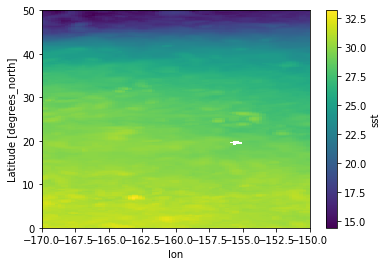

In [33]:
oisst_region.sst.max('time').plot()